## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## First, I'll define a helper method for printing images in a grid

In [1]:
def draw_annotated_image_grid(annotated_images, columns=3):
    """
    A helper method for drawing multiple images in a grid
    """
    rows = len(annotated_images) / columns + 1
    row_height = 12 / columns
    f = plt.figure(figsize=(20, row_height*rows)) # width, height in inches. If not provided, defaults to rc figure.figsize.
    f.tight_layout()
    for i, annotated_image in enumerate(annotated_images):
        title = annotated_image[0]
        image = annotated_image[1]
        splt = plt.subplot(rows, columns, i + 1)
        splt.set_title(title, fontsize=20)
        if len(annotated_image[1].shape) > 2:
            splt.imshow(image)
        else:
            splt.imshow(image, cmap='gray')
            
def draw_image_grid(images, columns=3):
    """
    A helper method for drawing multiple images in a grid
    """
    rows = len(images) / columns + 1
    row_height = 12 / columns
    f = plt.figure(figsize=(20, row_height*rows)) # width, height in inches. If not provided, defaults to rc figure.figsize.
    f.tight_layout()
    for i, img in enumerate(images):
        splt = plt.subplot(rows, columns, i + 1)
        if len(img.shape) > 2:
            splt.imshow(img)
        else:
            splt.imshow(img, cmap='gray')          

# Camera calibration and distortion correction

## Then I'll compute the camera calibration using chessboard images

Calibration succeeded


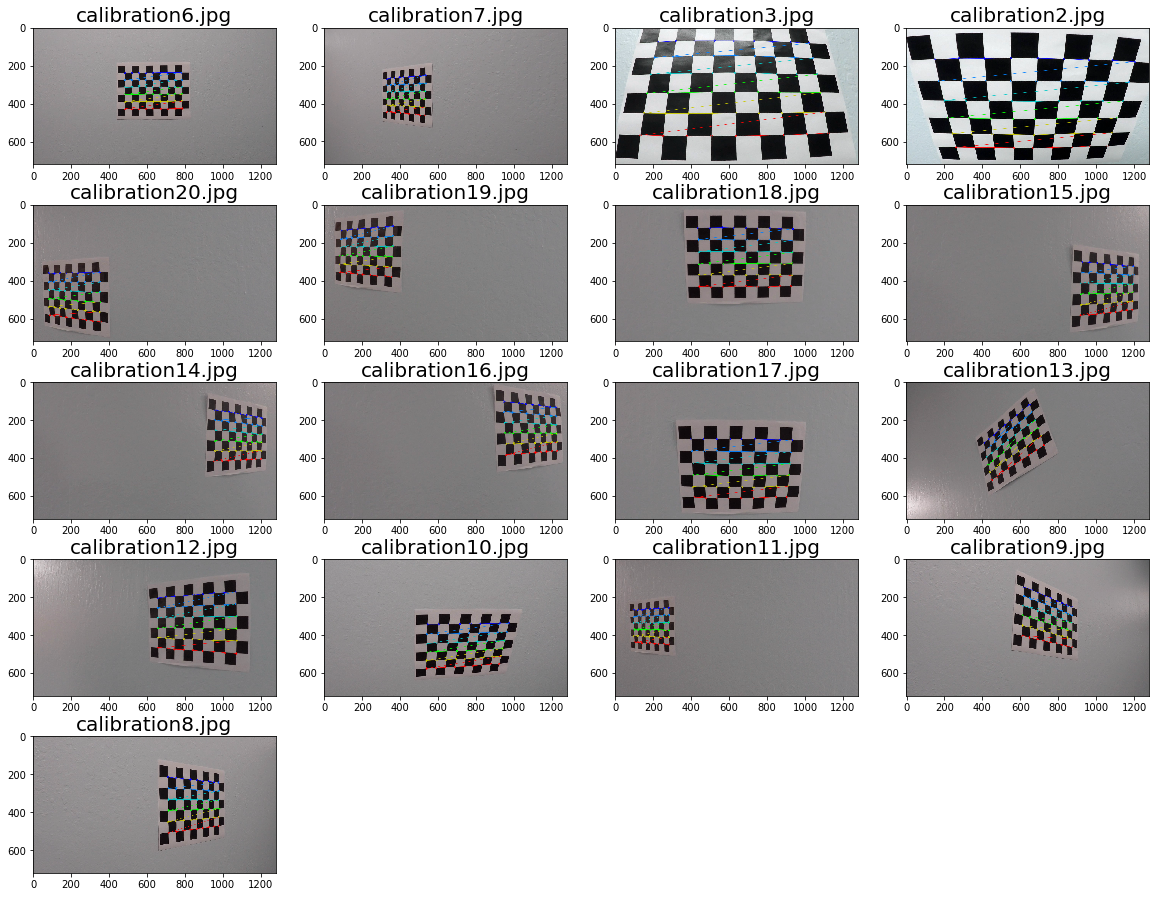

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt4
%matplotlib inline

def calibrate(cal_images, chessboard_nx, chassboard_ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chassboard_ny*chessboard_nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:chessboard_nx,0:chassboard_ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    img_shape = None

    chessboards = []

    # Step through the list and search for chessboard corners
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_shape = gray.shape[::-1]

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (chessboard_nx,chassboard_ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            img = cv2.drawChessboardCorners(img, (chessboard_nx,chassboard_ny), corners, ret)
            chessboards.append((fname.split('/')[-1], img))

    # Camera calibration, given object points, image points, and the shape of the grayscale image
    ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
    if not ret:
        raise Exception("Cannot calibrate camera")

    print("Calibration succeeded")
    return mtx, dist, chessboards
    
    
chessboard_nx = 9
chassboard_ny = 6

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Calibrates camera using chessboard images.
# We will reuse its output later in udistortion method.
cal_mtx, cal_dist, chessboards = calibrate(images, chessboard_nx, chassboard_ny)

draw_annotated_image_grid(chessboards, columns=4)

## And define the method for undistoring images

In [3]:
def undistort(img):
    """
    Distortion correction using the parameters gotten after camera calibration
    returns an undistorted image
    """
    return cv2.undistort(img, cal_mtx, cal_dist, None, cal_mtx)

## Undistorting images

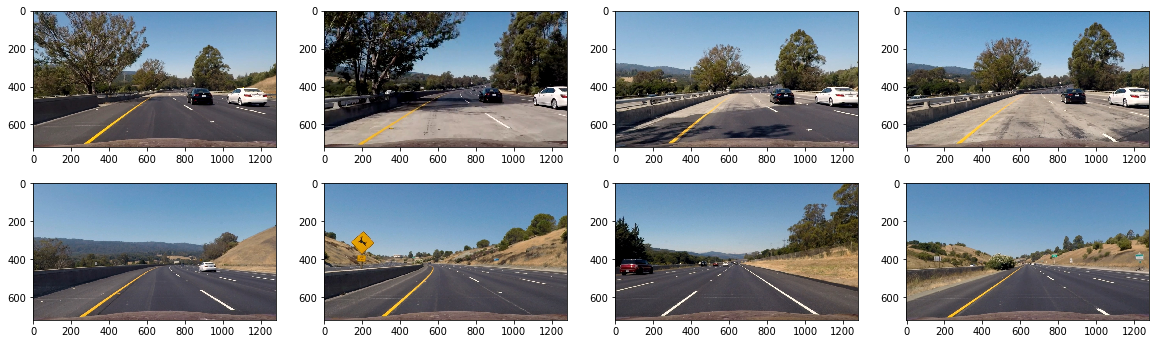

In [4]:
test_images_filename = glob.glob('./test_images/*.jpg')

test_images = []
for fname in test_images_filename:
    img = mpimg.imread(fname)
    test_images.append(img)
    
test_images_undist = []
for test_image in test_images:
    img_undist = undistort(test_image)
    test_images_undist.append(img_undist)
    
draw_image_grid(test_images_undist, 4)

# Perspective transformation

## Then I'll choose parameters for perspective transformation

Image (width,height)=(1280,720)
Lane width: 720px
Resolution: 0.00514 m/px


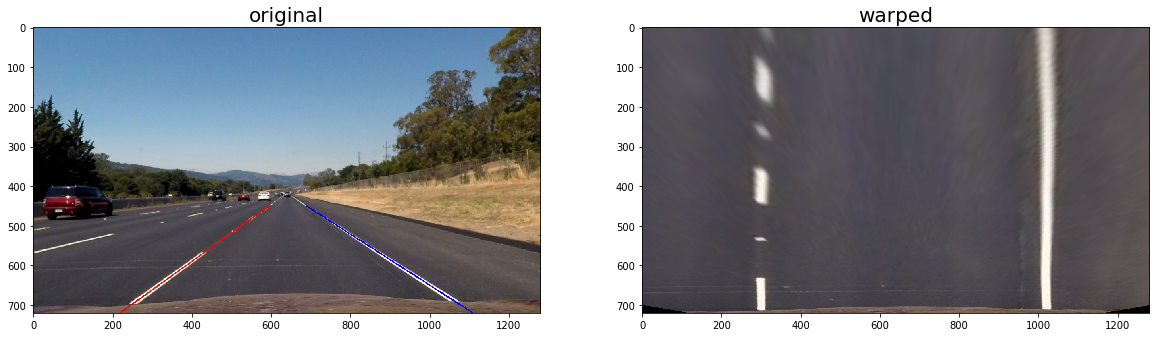

In [5]:
# Choosing parameters for perpective transformation
fname = './test_images/straight_lines2.jpg'
img = mpimg.imread(fname)

# defining global width and height as they woun't change
img_height = img.shape[0]
img_width = img.shape[1]

top_y = 450

lx1 = 218
ly1 = img_height
lx2 = 594
ly2 = top_y

rx1 = 1109
ry1 = img_height
rx2 = 689
ry2 = top_y

src = np.float32([
    [lx1, ly1], # bottom left
    [lx2, ly2], # top left
    [rx2, ry2], # top right
    [rx1, ry1]  # bottom right
]) 

lwx = 300 # left warped x-coordinate
rwx = 1020 # right warped x-coordinate
dst = np.float32([
    [lwx, img_height], # bottom left
    [lwx, 0],          # top left
    [rwx, 0],          # top right
    [rwx, img_height]  # bottom right
])

print('Image (width,height)=(%d,%d)' % (img_width, img_height))

warped_lane_width_px = rwx - lwx # lane width in pixels
warped_xm_per_px = 3.7 / warped_lane_width_px # the number of meters in a pixel
warped_ym_per_px = 30. / img_height # the number of meters in a pixel  

print('Lane width: %dpx' % warped_lane_width_px)
print('Resolution: %0.5f m/px' % warped_xm_per_px)

M = cv2.getPerspectiveTransform(src, dst)
Minv = np.linalg.inv(M)

img_undistorted = undistort(img)
img_warped = cv2.warpPerspective(img_undistorted, M, (img_width,img_height), flags=cv2.INTER_LINEAR)

cv2.line(img_undistorted, (lx1, ly1), (lx2, ly2), color=[255,0,0], thickness=2)
cv2.line(img_undistorted, (rx1, ry1), (rx2, ry2), color=[0,0,255], thickness=2)

draw_annotated_image_grid([('original', img_undistorted), ('warped', img_warped)], 2)

## And define a method for the perspective transformation

In [6]:
def birds_eye_view(img):
    img_size = (img.shape[1], img.shape[0])
    img_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return img_warped

## Let's apply perspective transformation to our test images

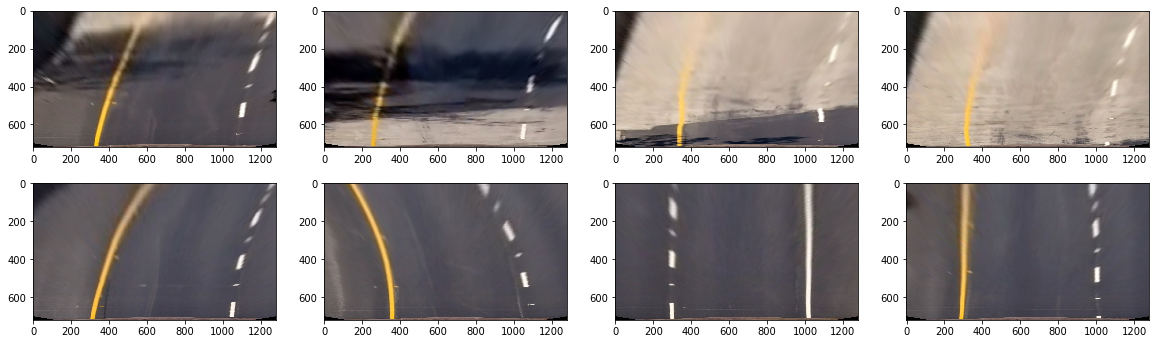

In [7]:
test_images_unwrap = []
for test_image in test_images_undist:
    img_unwrap = birds_eye_view(test_image)
    test_images_unwrap.append(img_unwrap)
    
draw_image_grid(test_images_unwrap, 4)

# Color thresholding and Gradient

## I'll define a few more helper methods

In [8]:
def grayscale(img):
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            
def to_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls[:,:,0], hls[:,:,1], hls[:,:,2]
    
def to_rgb(img):
    return img[:,:,0], img[:,:,1], img[:,:,2]
    
def scale_sobel(abs_sobel):
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    return scaled_sobel
    
def gray_to_sobel(gray, orient='x', ksize=3):
    if orient == 'x':
        ox = 1
        oy = 0
    else:
        ox = 0
        oy = 1
    return cv2.Sobel(gray, cv2.CV_64F, ox, oy, ksize=ksize)
    
def gray_to_scaled_sobel(gray, orient='x', ksize=3):
    sobel = gray_to_sobel(gray, orient, ksize)
    abs_sobel = np.absolute(sobel)
    return scale_sobel(abs_sobel)
    
def gray_to_scaled_mag(gray, ksize=3):
    sobelx = gray_to_sobel(gray, 'x', ksize)
    sobely = gray_to_sobel(gray, 'y', ksize)    
    sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    return scale_sobel(sobel)
    
def bin_mask(img, thresh=[0, 255]):
    bin_img = np.zeros_like(img)
    bin_img[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return bin_img
    
def grad_direction(gray, ksize=3):
    """
    An orientation of 0 implies a vertical line and orientations of +/−π/2 imply horizontal lines
    """
    sobelx = gray_to_sobel(gray, 'x', ksize)
    sobely = gray_to_sobel(gray, 'y', ksize)    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)    
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    return grad_dir

def curvature_radius(y, fit):
    return (1 + (2*fit[0]*y + fit[1])**2)**(3/2) / np.absolute(2*fit[0])  

def polinomial(y, fit):
    return fit[0]*y**2 + fit[1]*y + fit[2] 

## Checking RGB Color Space

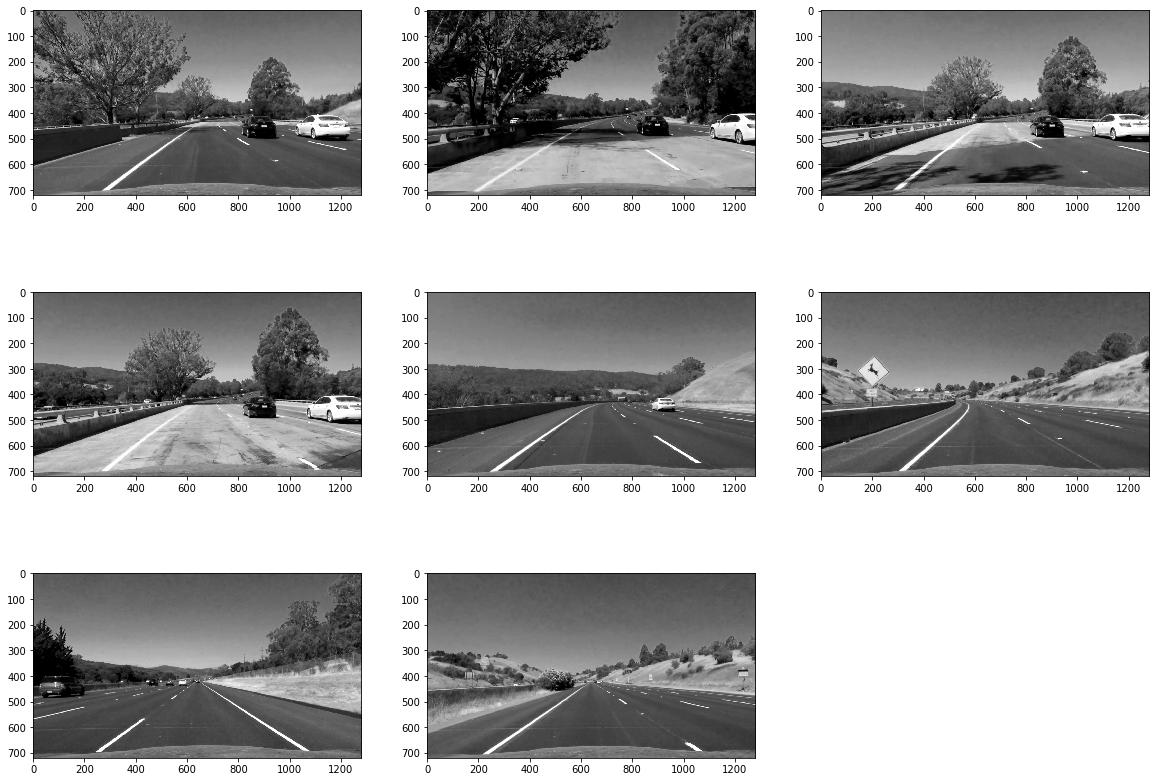

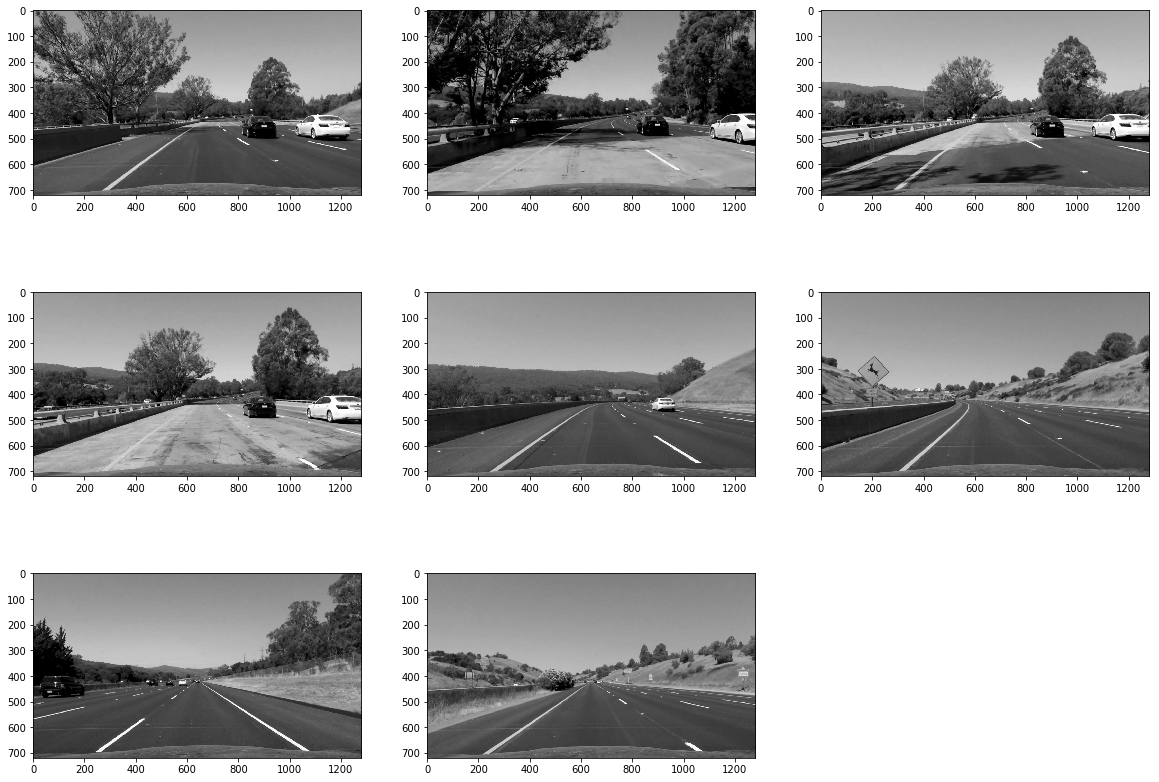

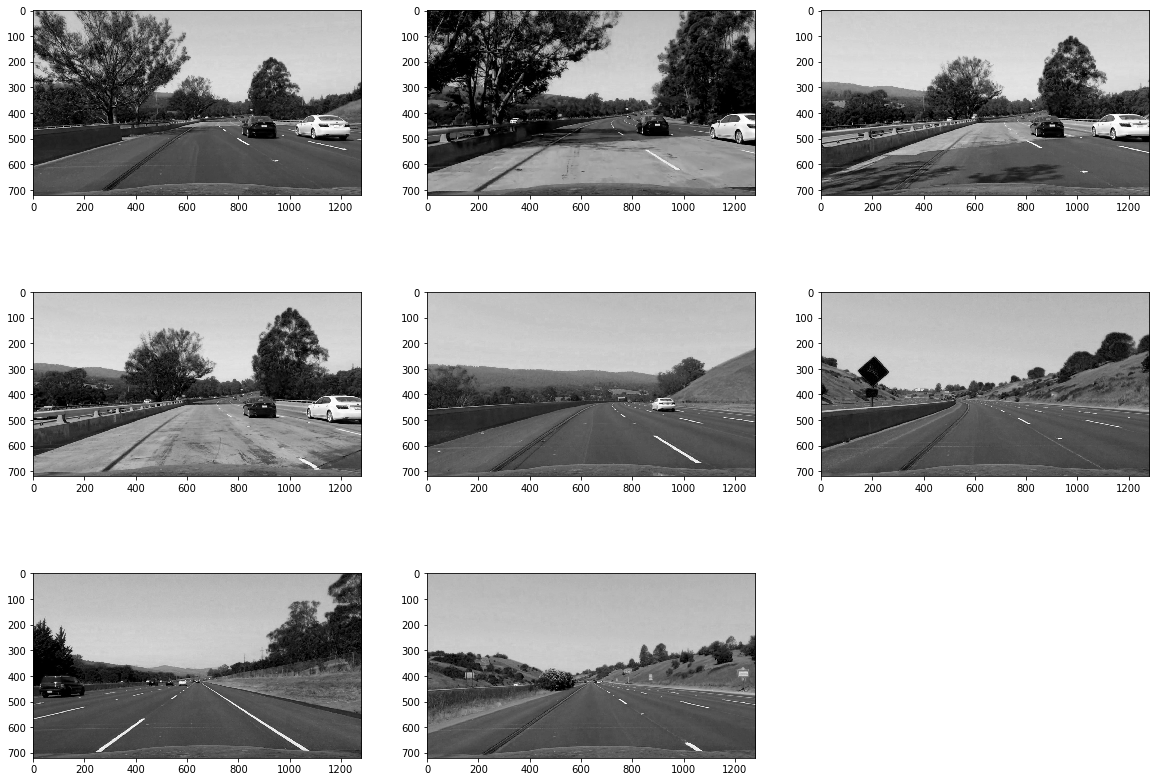

In [9]:
test_images_rgb_r = []
test_images_rgb_g = []
test_images_rgb_b = []
for test_image_undist in test_images_undist:
    rgb_r, rgb_g, rgb_b = to_rgb(test_image_undist)
    test_images_rgb_r.append(rgb_r)
    test_images_rgb_g.append(rgb_g)
    test_images_rgb_b.append(rgb_b)
    
draw_image_grid(test_images_rgb_r, 3)
draw_image_grid(test_images_rgb_g, 3)
draw_image_grid(test_images_rgb_b, 3)

## Checking HLS

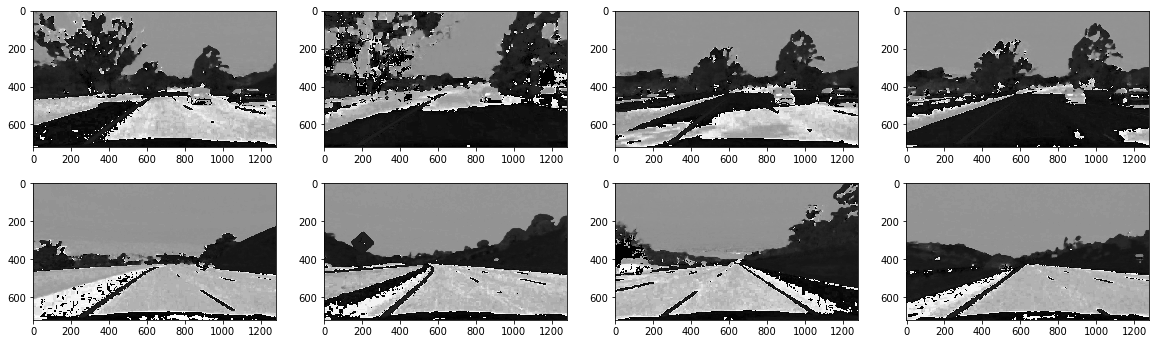

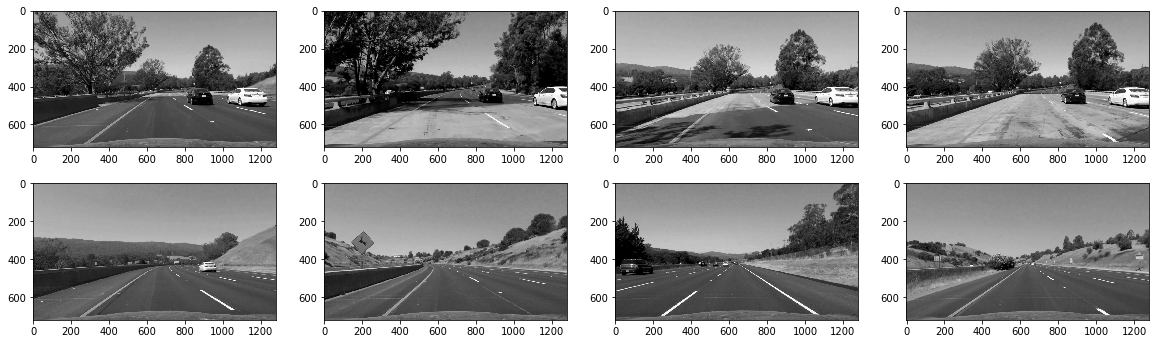

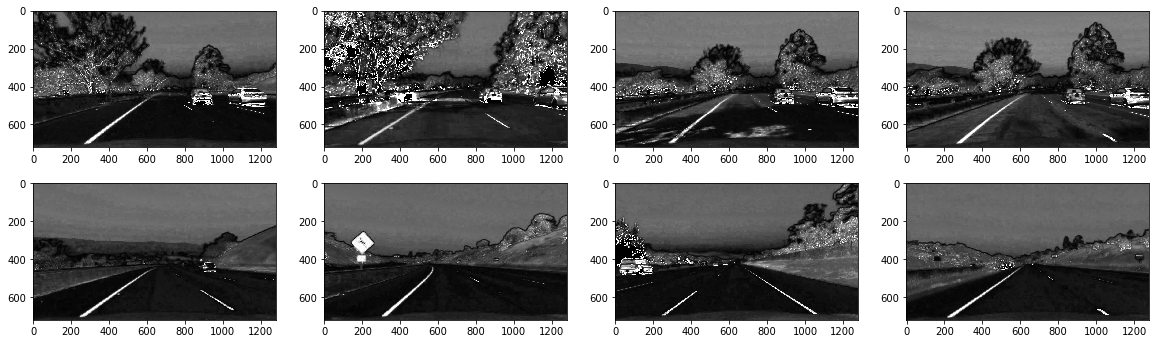

In [10]:
test_images_hls_h = []
test_images_hls_l = []
test_images_hls_s = []
for test_image_undist in test_images_undist:
    hls_h, hls_l, hls_s = to_hls(test_image_undist)
    test_images_hls_h.append(hls_h)
    test_images_hls_l.append(hls_l)
    test_images_hls_s.append(hls_s)
    
draw_image_grid(test_images_hls_h, 4)
draw_image_grid(test_images_hls_l, 4)
draw_image_grid(test_images_hls_s, 4)

## Playing with RGB-R thresholding

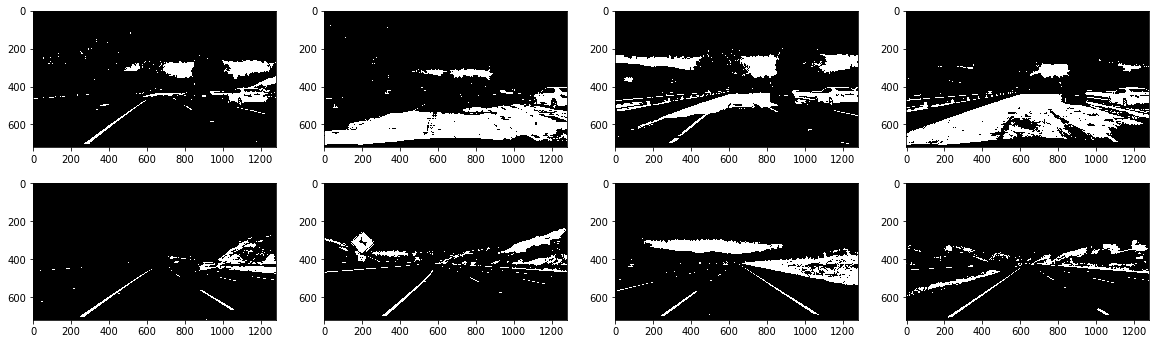

In [11]:
rgb_r_thresholded = []
for test_image in test_images_rgb_r:
    thresh = bin_mask(test_image, [170, 255])*255
    rgb_r_thresholded.append(thresh)
    
draw_image_grid(rgb_r_thresholded, 4)

## Playing with RGB-G thresholding

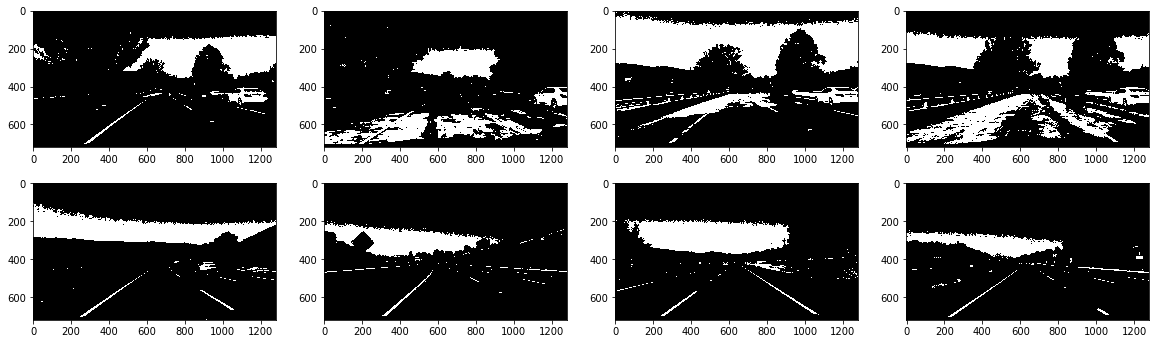

In [12]:
rgb_g_thresholded = []
for test_image in test_images_rgb_g:
    thresh = bin_mask(test_image, [170, 255])*255
    rgb_g_thresholded.append(thresh)
    
draw_image_grid(rgb_g_thresholded, 4)

## Playing with RGB-R&G thresholding

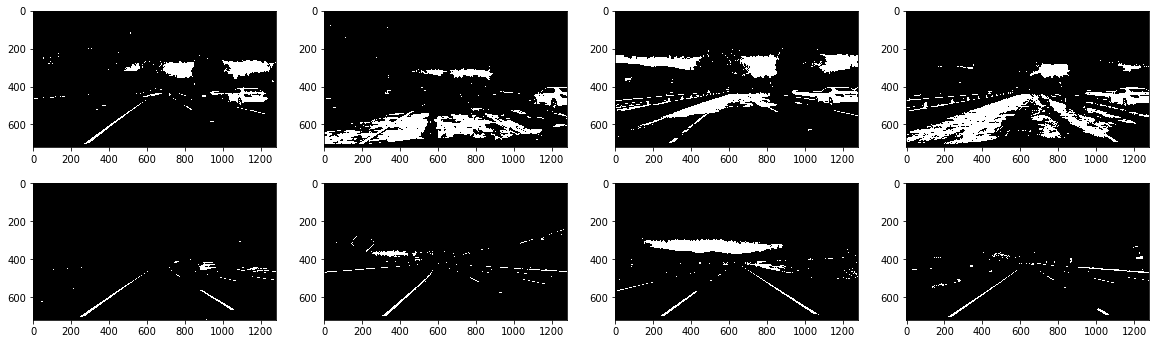

In [13]:
rgb_rg_thresholded = []
for i in range(len(test_images_rgb_g)):
    test_image_r = test_images_rgb_r[i]
    test_image_g = test_images_rgb_g[i]   
    
    thresh_r = bin_mask(test_image_r, [170, 255])
    thresh_g = bin_mask(test_image_g, [170, 255])    
    
    thresh = np.zeros_like(thresh_r)
    thresh[(thresh_r == 1) & (thresh_g == 1)] = 1
    
    rgb_rg_thresholded.append(thresh)
    
draw_image_grid(rgb_rg_thresholded, 4)

## Playing with HLS-H thresholding

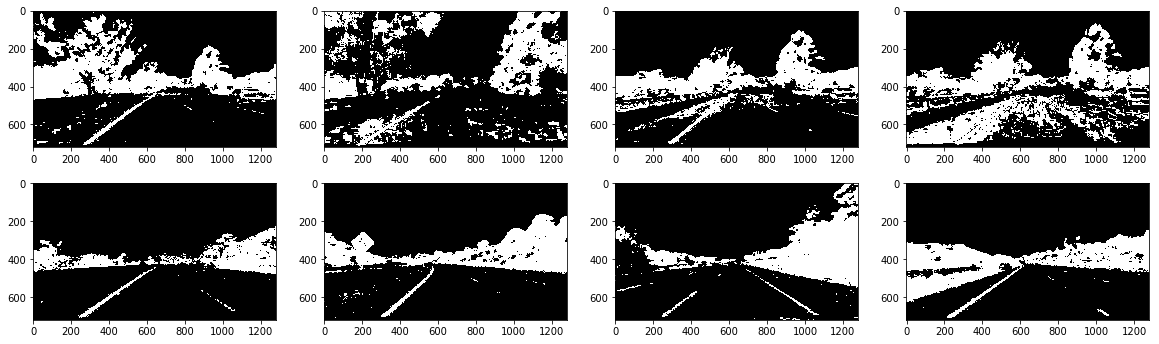

In [14]:
hls_h_thresholded = []
for test_image in test_images_hls_h:
    thresh = bin_mask(test_image, [15, 40])*255
    hls_h_thresholded.append(thresh)
    
draw_image_grid(hls_h_thresholded, 4)

## Playing with HLS-S thresholding

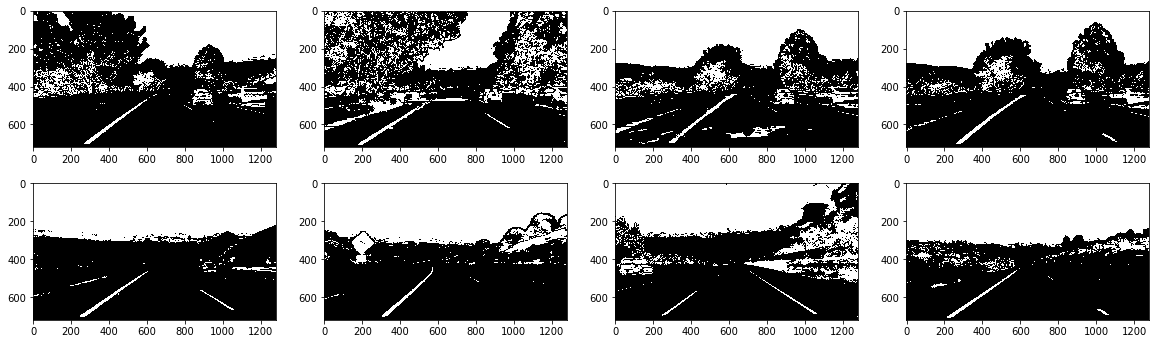

In [15]:
hls_s_thresholded = []
for test_image in test_images_hls_s:
    thresh = bin_mask(test_image, [90, 255])*255
    hls_s_thresholded.append(thresh)
    
draw_image_grid(hls_s_thresholded, 4)

## Playing with HLS-L X-gradient 

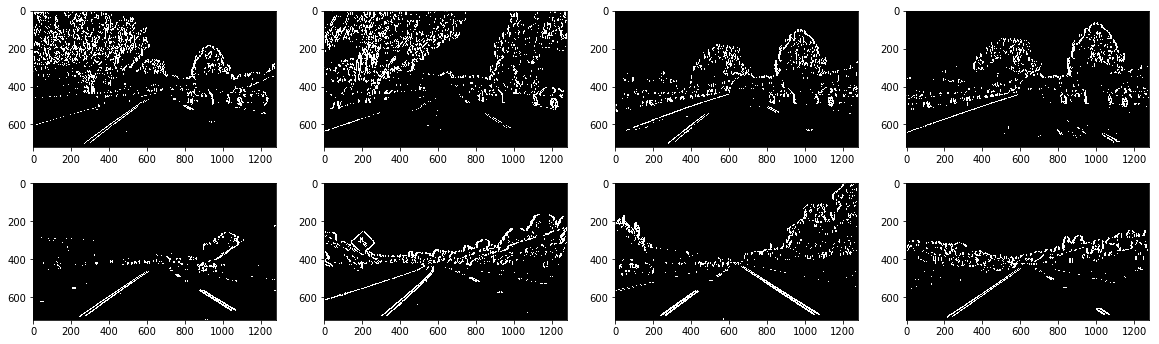

In [16]:
hls_l_thresholded = []
for test_image in test_images_hls_l:
    grad = gray_to_scaled_sobel(test_image, ksize=31)
    thresh = bin_mask(grad, [40, 255])*255
    hls_l_thresholded.append(thresh)
    
draw_image_grid(hls_l_thresholded, 4)

## Playing with HLS-L gradient direction

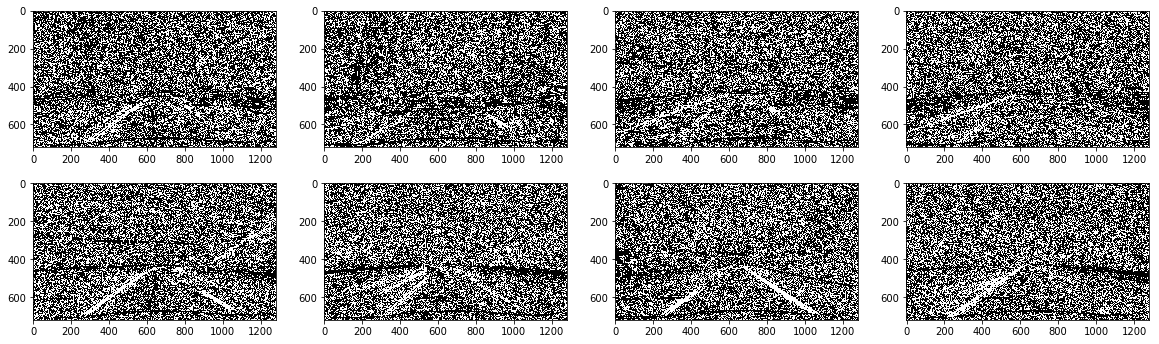

In [17]:
hls_l_thresholded = []
for test_image in test_images_hls_l:
    grad = grad_direction(test_image, ksize=15)
    thresh = bin_mask(grad, [0.7, 1.3])*255
    hls_l_thresholded.append(thresh)
    
draw_image_grid(hls_l_thresholded, 4)

## Putting all thresholds together

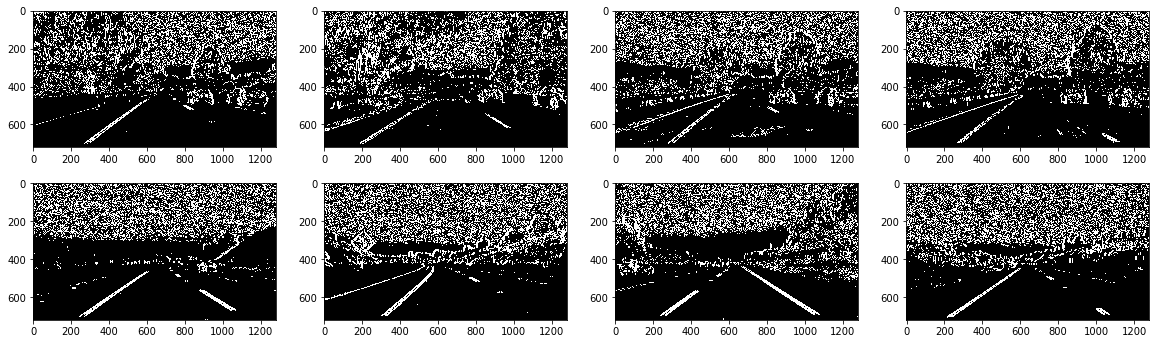

In [18]:
hls_ls_thresholded = []
for i in range(len(test_images_hls_s)):
    img_hls_s = test_images_hls_s[i]
    img_hls_l = test_images_hls_l[i]     
    
    thresh_s = bin_mask(img_hls_s, [90, 255])
    
    mask_rgs = (thresh_s == 1)
    
    grad_dir = grad_direction(img_hls_l, ksize=15)
    thresh_gr_dir = bin_mask(grad_dir, [0.7, 1.3])
    
    mask_gr_dir = mask_rgs & (thresh_gr_dir == 1)
    
    grad = gray_to_scaled_sobel(img_hls_l, ksize=31)
    thresh_dr = bin_mask(grad, [40, 255])
    
    thresh = np.zeros_like(thresh_s)
    thresh[mask_gr_dir | (thresh_dr == 1)] = 1
    
    hls_ls_thresholded.append(thresh)
    
draw_image_grid(hls_ls_thresholded, 4)

## Defining a method for Color thresholding and Gradient

In [19]:
def thresh(img):
    """
    returns a thresholded image and a list of steps
    """
    steps = []
          
    _, img_hls_l, img_hls_s = to_hls(img)
    
    thresh_s = bin_mask(img_hls_s, [90, 255])
    
    mask_rgs = (thresh_s == 1)
    
    grad_dir = grad_direction(img_hls_l, ksize=15)
    thresh_gr_dir = bin_mask(grad_dir, [0.7, 1.3])
    
    mask_gr_dir = mask_rgs & (thresh_gr_dir == 1)
    
    grad = gray_to_scaled_sobel(img_hls_l, ksize=31)
    thresh_dr = bin_mask(grad, [40, 255])
    
    result_thresh = np.zeros_like(thresh_s)
    result_thresh[mask_gr_dir | (thresh_dr == 1)] = 1    
    
    steps.append(('Result thresh', result_thresh))
    
    return (result_thresh, steps)

# Lane-finding

## Let's define two classes for keeping state between detection iterations

In [20]:
from collections import deque

# Represents a line on a warped image
class Line():
    def __init__(self, allx, ally):
        #x values for detected line pixels
        self.allx = allx
        #y values for detected line pixels
        self.ally = ally        
        #polynomial coefficients for fit
        self.fit = np.polyfit(ally, allx, 2)

# Keeps a state between single detection iterations
class LineDetector():
    def __init__(self, history_depth):
        # was the line detected in the last iteration?
        self.detected = False    
        # polynomial coefficients of the last n iterations
        self.recent_fits = deque([], history_depth)
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        # distance in meters of vehicle center from the line
        self.line_base_pos = 0
        
    def update(self, line):
        self.current_line = line
        self.detected = line is not None
        if self.detected:
            self.recent_fits.append(line.fit)                
            n = len(self.recent_fits)
            self.best_fit = np.average(self.recent_fits, axis=0, weights=np.linspace(1, n, n))
            
            # calculating radius of curvature
            lane_length_m = warped_ym_per_px * img_height
            self.radius_of_curvature = int(curvature_radius(lane_length_m, self.best_fit))
            
            # calculating line base position
            fit = self.best_fit
            y_pos = img_height
            line_pos_px = fit[0]*y_pos**2 + fit[1]*y_pos + fit[2]
            line_base_pos_px = line_pos_px - (img_width / 2)
            self.line_base_pos = line_base_pos_px * warped_xm_per_px

## Sliding window search

In [21]:
def find_lane_pixels(binary_warped):    
    # Take a histogram of the bottom half of the image
    half_binary_warped = binary_warped[img_height//2:,:]
    histogram = np.sum(half_binary_warped, axis=0)
    # Create an output image to draw on and visualize the result
    img_lane_pixels = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    img_histogram = np.dstack((half_binary_warped, half_binary_warped, half_binary_warped))*255
    plotx = np.linspace(0, binary_warped.shape[1]-1, binary_warped.shape[1])
    pts = np.vstack((plotx,img_histogram.shape[0]-histogram)).astype(np.int32).T
    cv2.polylines(img_histogram, [pts], isClosed=False, color=[255,0,0], thickness=2)
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_height - (window+1)*window_height
        win_y_high = img_height - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(img_lane_pixels,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(img_lane_pixels,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    img_lane_pixels[lefty, leftx] = [255, 0, 0]
    img_lane_pixels[righty, rightx] = [0, 0, 255]
    
    if len(leftx) != 0 and len(lefty) != 0:
        left_line = Line(leftx, lefty)
    else:
        left_line = None
        
    if len(rightx) != 0 and len(righty) != 0:
        right_line = Line(rightx, righty)
    else:
        right_line = None
    
    try:
        left_fit = left_line.fit
        right_fit = right_line.fit
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_height-1, img_height)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    
        l_pts = np.vstack((left_fitx,ploty)).astype(np.int32).T
        r_pts = np.vstack((right_fitx,ploty)).astype(np.int32).T
        cv2.polylines(img_lane_pixels, [l_pts], isClosed=False, color=[255,255,0])
        cv2.polylines(img_lane_pixels, [r_pts], isClosed=False, color=[255,255,0])
    except Exception:
        pass    
    
    return left_line, right_line, img_lane_pixels, img_histogram

## Search around poly

In [22]:
def search_around_poly(binary_warped, left_fit, right_fit):
    margin = 100
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    ax = left_fit[0]
    bx = left_fit[1]
    cx = left_fit[2]
    left_lane_inds = ((nonzerox >= ax*nonzeroy**2 + bx*nonzeroy + cx - margin) & 
    (nonzerox < ax*nonzeroy**2 + bx*nonzeroy + cx + margin))
    
    ax = right_fit[0]
    bx = right_fit[1]
    cx = right_fit[2]
    right_lane_inds = ((nonzerox >= ax*nonzeroy**2 + bx*nonzeroy + cx - margin) & 
    (nonzerox < ax*nonzeroy**2 + bx*nonzeroy + cx + margin)) 
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]    
    
    if len(leftx) != 0 and len(lefty) != 0:
        left_line = Line(leftx, lefty)
    else:
        left_line = None
        
    if len(rightx) != 0 and len(righty) != 0:
        right_line = Line(rightx, righty)
    else:
        right_line = None
    
    return left_line, right_line

## Sanity check

Parallel:  True


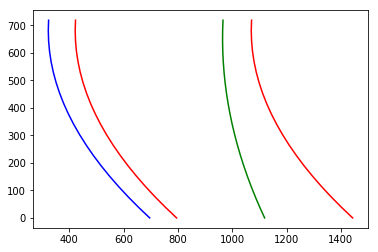

In [23]:
# Searching line parallelizm criteria

lfit= [ 8.03526319e-04, -1.09527019e+00,  6.96159723e+02] 
rfit= [ 3.63370735e-04, -4.74419347e-01,  1.11918439e+03]

left_fit = np.array(lfit)
right_fit = np.array(rfit)

ploty = np.linspace(0, 720-1, 20)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    
margin = 0.9 * (warped_lane_width_px / 2)
left_border_fit = np.copy(left_fit)
left_border_fit[2] += right_fit[2] - left_fit[2] - margin
left_border_fitx = left_border_fit[0]*ploty**2 + left_border_fit[1]*ploty + left_border_fit[2]    
    
right_border_fit = np.copy(left_fit)
right_border_fit[2] += right_fit[2] - left_fit[2] + margin
right_border_fitx = right_border_fit[0]*ploty**2 + right_border_fit[1]*ploty + right_border_fit[2]  
    
parallel = len(right_fitx[(right_fitx < left_border_fitx) | (right_fitx > right_border_fitx)]) == 0
print('Parallel: ', parallel)
    
plt.plot(left_fitx, ploty, 'b', right_fitx, ploty, 'g', 
         left_border_fitx, ploty, 'r', right_border_fitx, ploty, 'r')

In [24]:
# Checks that the left and right lines have similar curvature and roughly parallel.
def sanity_check_topology(left_fit, right_fit):
    ploty = np.linspace(0, img_height - 1, 20)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    

    margin = 0.9 * (warped_lane_width_px / 2)
    
    # Creates two "borders" for the right line.
    # Each "border" is a copy of the left line moved to the right line's position +/- margin
    
    left_border_fit = np.copy(left_fit)
    left_border_fit[2] += right_fit[2] - left_fit[2] - margin
    left_border_fitx = left_border_fit[0]*ploty**2 + left_border_fit[1]*ploty + left_border_fit[2]    

    right_border_fit = np.copy(left_fit)
    right_border_fit[2] += right_fit[2] - left_fit[2] + margin
    right_border_fitx = right_border_fit[0]*ploty**2 + right_border_fit[1]*ploty + right_border_fit[2]  

    # Check if the right line is within the left and right borders
    passed = len(right_fitx[(right_fitx < left_border_fitx) | (right_fitx > right_border_fitx)]) == 0
    
    if not passed:
        print('Topology check failed, lfit=', left_fit, 'rfit=', right_fit)    
    
    return passed

# Checks that the left and right lines are separated 
# by approximately the right distance horizontally
def sanity_check_distance(left_fit, right_fit):
    left_pos = polinomial(img_height, left_fit)
    right_pos = polinomial(img_height, right_fit)
    distance_px = right_pos - left_pos
    diff_px = np.absolute(warped_lane_width_px - distance_px)
    diff_m = diff_px * warped_xm_per_px # diff in meters
    passed = diff_m < 0.5 # allows 50cm diff
    if not passed:
        print('Distance check failed, diff_m=', diff_m)
    return passed, distance_px * warped_xm_per_px

def sanity_check(left_line, right_line):
    # Checking that we found both left and right lines
    if left_line is None or right_line is None:
        return False
    
    if not sanity_check_distance(left_line.fit, right_line.fit):
        return False
    
    if not sanity_check_topology(left_line.fit, right_line.fit):
        return False
    
    return True

## Next step is defining a pipeline for processing a single image frame

In [25]:
def pipeline(img, left_det=None, right_det=None):    
    history_depth = 1
    
    if left_det is None:
        left_det = LineDetector(history_depth)
    
    if right_det is None:
        right_det = LineDetector(history_depth)
    
    steps = []
    
    steps.append(('original', img))
    
    # Applying a distortion correction to the raw image.
    img_undist = undistort(img)
    steps.append(('undistorted', img_undist))
    
    # Use color transforms, gradients, etc., to create a thresholded binary image.
    img_thresholded, thr_steps = thresh(img_undist)
    steps.extend(thr_steps)  
    
    # Apply a perspective transform to rectify binary image ("birds-eye view").
    img_warped = birds_eye_view(img_thresholded)
    steps.append(('warped', img_warped))
    
    # Find our lane pixels first
    if left_det.detected and right_det.detected:
        lline, rline = search_around_poly(img_warped, left_det.best_fit, right_det.best_fit)
        if not sanity_check(lline, rline):
            print('Sanity check failed after search_around_poly')
            lline, rline, img_lane_pixels, img_histogram = find_lane_pixels(img_warped)
            steps.append(('histogram', img_histogram))
            steps.append(('lane pixels', img_lane_pixels))            
    else:
        lline, rline, img_lane_pixels, img_histogram = find_lane_pixels(img_warped)
        steps.append(('histogram', img_histogram))
        steps.append(('lane pixels', img_lane_pixels))
    
    # Checking if the lines are correct
    if sanity_check(lline, rline):
        left_det.update(lline)
        right_det.update(rline)
    else:
        print('Sanity check failed')
        left_det.update(None)
        right_det.update(None) 
    
    # Determine the curvature of the lane and vehicle position with respect to center.
        
    left_fit = left_det.best_fit
    right_fit = right_det.best_fit
    
    if left_fit is None or right_fit is None:
        return img_undist, steps
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_height-1, img_height)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    

    # Warp the detected lane boundaries back onto the original image
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    color_warp_poly = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp_lines = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp_poly, np.int_([pts]), (0,255,0))

    color_warp_lines[lline.ally, lline.allx] = [255, 0, 0]
    color_warp_lines[rline.ally, rline.allx] = [100, 0, 255]
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp_poly = cv2.warpPerspective(color_warp_poly, Minv, (img_width, img_height)) 
    newwarp_lines = cv2.warpPerspective(color_warp_lines, Minv, (img_width, img_height))     
    
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp_poly, 0.3, 0)
    result = cv2.addWeighted(result, 0.7, newwarp_lines, 0.5, 0)    
    steps.append(('result', result))
    
    left_curverad = left_det.radius_of_curvature
    right_curverad = right_det.radius_of_curvature
    curverad = (left_curverad + right_curverad) // 2
    
    check_top = sanity_check_topology(left_fit, right_fit)
    check_dist, _ = sanity_check_distance(left_fit, right_fit)    
    
    # Calculating vehicle position with respect to center.
    position_m = (right_det.line_base_pos + left_det.line_base_pos) / 2
    if position_m > 0:
        side = "left"
    else:
        side = "right"    
    
    fontScale=1
    offset = 40
    texts = [
        "Radius of Curvature (l) = %dm" % left_curverad,
        "Radius of Curvature (r) = %dm" % right_curverad,
        "Vehicle is %0.2fm %s of center" % (np.absolute(position_m), side)
    ]
    
    for i in range(len(texts)):
        text = texts[i]
        cv2.putText(result, text, (30, offset*(i+1)), 
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=fontScale, 
                    color=[255,255,255], thickness=2)     

    return result, steps

# Testing the pipeline on test images

In [26]:
import os
os.listdir('./test_images/')

['test6.jpg',
 'test5.jpg',
 'test4.jpg',
 'test1.jpg',
 'test3.jpg',
 'test2.jpg',
 'straight_lines2.jpg',
 'straight_lines1.jpg',
 '.ipynb_checkpoints']

Processing  ./test_images/test6.jpg
Processing  ./test_images/test5.jpg
Processing  ./test_images/test4.jpg
Processing  ./test_images/test1.jpg
Processing  ./test_images/test3.jpg
Processing  ./test_images/test2.jpg
Processing  ./test_images/straight_lines2.jpg
Processing  ./test_images/straight_lines1.jpg


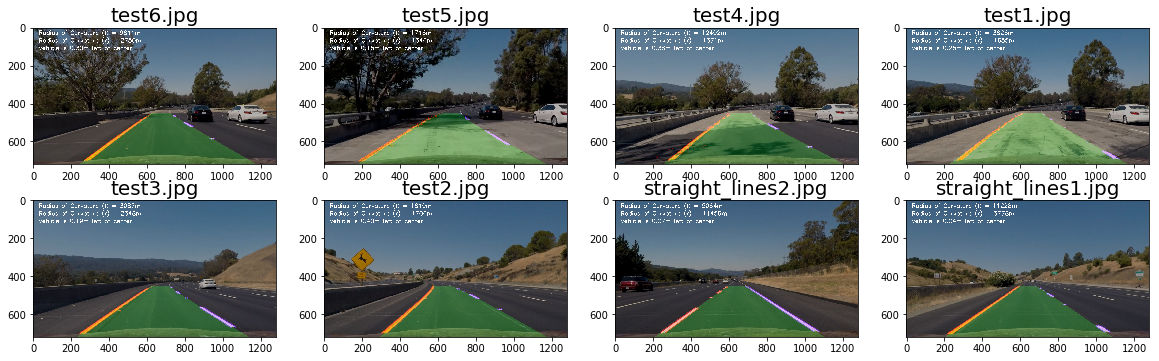

In [27]:
debug_one = False
#debug_image = './test_images/straight_lines1.jpg'
debug_image = './test_images/test1.jpg'
print_steps = debug_one
print_result = not print_steps

test_images = glob.glob('./test_images/*.jpg')
results = []
for fname in test_images:
    if debug_one and fname != debug_image:
        continue
    print('Processing ', fname)
    img = mpimg.imread(fname)
    result, steps = pipeline(img)
    results.append((fname.split('/')[-1], result))
    if print_steps:
        draw_annotated_image_grid(steps, 2)
    
if print_result:
    draw_annotated_image_grid(results, 4)

# Applying the pipeline to the project video

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_det = None
right_det = None
def process_image(image):
    global left_det
    global right_det
    if left_det is None or right_det is None:
        print('Initializing line detectors')
        history_depth = 30  
        left_det = LineDetector(history_depth)
        right_det = LineDetector(history_depth)
        
    result, _ = pipeline(image, left_det, right_det)
    return result

In [29]:
left_det = None
right_det = None

#filename = 'harder_challenge_video.mp4'
#filename = 'challenge_video.mp4'
filename = 'project_video.mp4'

white_output = 'output_videos/%s' % filename
#clip1 = VideoFileClip(filename).subclip(0,5) # the first five seconds for debugging
#clip1 = VideoFileClip(filename).subclip(28,35)
clip1 = VideoFileClip(filename)

white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

Initializing line detectors
[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


 48%|████▊     | 601/1261 [02:00<02:12,  5.00it/s]

Distance check failed, diff_m= 0.7297203735708625
Distance check failed, diff_m= 0.7297203735708625
Distance check failed, diff_m= 0.6121303128359797
Distance check failed, diff_m= 0.6121303128359797


 48%|████▊     | 603/1261 [02:00<02:11,  5.00it/s]

Distance check failed, diff_m= 0.5489780079599778
Distance check failed, diff_m= 0.5489780079599778
Distance check failed, diff_m= 0.5438401629658838
Distance check failed, diff_m= 0.5438401629658838


 50%|████▉     | 626/1261 [02:05<02:06,  5.00it/s]

Topology check failed, lfit= [ 1.00870243e-03 -1.48632297e+00  8.31337764e+02] rfit= [ 4.38197722e-04 -6.24051865e-01  1.24366983e+03]
Sanity check failed after search_around_poly
Topology check failed, lfit= [ 1.02759710e-03 -1.50967315e+00  8.38461615e+02] rfit= [ 4.26737221e-04 -6.14314970e-01  1.24197958e+03]
Sanity check failed


 50%|████▉     | 627/1261 [02:05<02:06,  5.00it/s]

Topology check failed, lfit= [ 1.05694991e-03 -1.54668533e+00  8.51832098e+02] rfit= [ 4.30983430e-04 -6.24142587e-01  1.25036834e+03]
Sanity check failed
Topology check failed, lfit= [ 9.71127916e-04 -1.49557191e+00  8.61922513e+02] rfit= [ 5.27358093e-04 -6.92059911e-01  1.25625042e+03]
Sanity check failed

 50%|████▉     | 628/1261 [02:05<02:06,  5.00it/s]

 80%|███████▉  | 1005/1261 [03:19<00:50,  5.03it/s]

Distance check failed, diff_m= 0.5406840333338205
Distance check failed, diff_m= 0.5406840333338205


100%|█████████▉| 1260/1261 [04:10<00:00,  5.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 4min 55s, sys: 50.4 s, total: 5min 45s
Wall time: 4min 11s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))